In [14]:
import numpy as np
import sympy as sp
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt
from scipy import optimize as opt
from statsmodels.stats.diagnostic import lilliefors
sp.init_printing(use_unicode=False, wrap_line=False, no_global=True)
from IPython.display import display, Markdown, Latex

file_path = 'data.xlsx'
data = pd.read_excel(file_path)
gpa = data.iloc[:, 0]  
gtk = data.iloc[:, 1]
gtk = gtk.dropna()

### Задание 1.9. Цензурированные выборки ###

#### *1. Методом максимального правдоподобия оцените параметр $\lambda$ распределения наработки ГПА до отказа. Постройте доверительный интервал для оценки, считая ее распределение нормальным. Сравните результат с оценкой без учета цензурированности выборки* ####

В испытаниях участвуют $n$ объектов. Моменты отказов $t_i$ регистрируются в течение времени $T$, затем регистрация прекращается. При расчетах статистических показателей необходимо учитывать не только значения $t_i$, но и количество агрегатов $k$, все еще работоспособных к моменту $T$. Такие выборки называются цензурированными.

Методом максимального правдоподобия можно получить оценку параметра $\lambda$ экспоненциального распределения для цензурированной выборки:
$$\widehat{\lambda}=\frac{n-k}{\sum{t_i}+kT}$$
Для больших выборок распределение $\widehat{\lambda}$ близко к нормальному причём:
$$M\widehat{\lambda}=\lambda$$
$$D\widehat{\lambda}=\frac{\lambda^2}{(1-e^{-\lambda T})n}$$

In [15]:
T = 2*365*24
ts = gpa
sts = sum(ts)
n = 65
k = 5

In [16]:
lyambda_est = (n-k)/(sts+k*T)
lyambda = sp.symbols(r'\hat{\lambda}')
sp.Eq(lyambda, lyambda_est)

Считая распределение оценки нормальным (по условию задачи):
$$\widehat{\lambda}\sim N(\lambda, \frac{\lambda^2}{(1-e^{-\lambda T})n})$$
$$\frac{\widehat{\lambda}-M\widehat{\lambda}}{\sqrt{D\widehat{\lambda}}}\sim N(0,1)$$

Для нахождения доверительного интервала с уровнем значимости $\alpha$, найдём квантили $\frac{\alpha}{2}$ и $(1-\frac{\alpha}{2})$ уровней стандартного нормального распределения: $c_{\frac{\alpha}{2}}$, $c_{1-\frac{\alpha}{2}}$.

Из условия симметрии стандартного нормального распределения: $c_\frac{\alpha}{2}=-c_{1-\frac{\alpha}{2}}$

$$c_\frac{\alpha}{2}\le \frac{\widehat{\lambda}-M\widehat{\lambda}}{\sqrt{D\widehat{\lambda}}}\le c_{1-\frac{\alpha}{2}}$$
$$-c_{1-\frac{\alpha}{2}}\le \frac{\widehat{\lambda}-\lambda}{\sqrt{D\widehat{\lambda}}}\le c_{1-\frac{\alpha}{2}}$$
$$\widehat{\lambda}-c_{1-\frac{\alpha}{2}}\sqrt{D\widehat{\lambda}}\le \lambda\le \widehat{\lambda}+c_{1-\frac{\alpha}{2}}\sqrt{D\widehat{\lambda}}$$

In [17]:
var_lambda_est = lyambda_est**2 / ((1 - np.exp(-lyambda_est*T)) * n)
std_lambda_est = np.sqrt(var_lambda_est)
sqrt_D_lambda = sp.symbols(r'\sqrt{D\hat{\lambda}}')
sp.Eq(sqrt_D_lambda, std_lambda_est)

In [18]:
lyambda = sp.symbols('lambda')
alpha = 0.05
quantile = st.norm.ppf(1-alpha/2)
lower_bound = lyambda_est - quantile*std_lambda_est
upper_bound = lyambda_est + quantile*std_lambda_est
sp.And(sp.LessThan(lower_bound, lyambda), sp.LessThan(lyambda, upper_bound))

In [20]:
lyambda_nc_value = (n-k)/sts
display(Latex('$$\large{\widehat{\lambda}_{nc}=\\frac{n-k}{\sum{t_i}}='+format(lyambda_nc_value, '.8f')+'>'+format(lyambda_est, '.8f')+'=\widehat{\lambda}}$$'))

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\w'
C:\Users\kosti\AppData\Local\Temp\ipykernel_11500\3615372068.py:2: SyntaxWarning: invalid escape sequence '\l'
  display(Latex('$$\large{\widehat{\lambda}_{nc}=\\frac{n-k}{\sum{t_i}}='+format(lyambda_nc_value, '.8f')+'>'+format(lyambda_est, '.8f')+'=\widehat{\lambda}}$$'))
C:\Users\kosti\AppData\Local\Temp\ipykernel_11500\3615372068.py:2: SyntaxWarning: invalid escape sequence '\w'
  display(Latex('$$\large{\widehat{\lambda}_{nc}=\\frac{n-k}{\sum{t_i}}='+format(lyambda_nc_value, '.8f')+'>'+format(lyambda_est, '.8f')+'=\widehat{\lambda}}$$'))


<IPython.core.display.Latex object>

#### *2. Постройте оценку вероятности безотказной работы агрегатов методом Каплана-Майера и доверительный интервал для нее. Сравните с параметрической оценкой на основе экспоненциального распределения* ####

Пусть $n_i$ - количество объектов, работоспособных к моменту $t_i$. Тогда выборочная вероятность безотказной работы равна
$$\widehat{R}(t)=\prod_{i|t_i\le t}{\left(1-\frac1{n_i}\right)}$$

Известно, что $\widehat{R}(t)\in N(R(t), \sigma(t))$ при $n\to\infty$, где
$$\sigma^2(t)=R^2(t)\sum_{i|t_i\le t}{\frac1{n_i(n_i-1)}}$$
При построение доверительного интервала можно заменить $R(t)$ на её оценку $\widehat{R}(t)$

In [21]:
n_i = lambda t: n-len(ts[ts <= t])
R_est = lambda t: np.prod([(1-1/n_i(t_i)) for t_i in ts if t_i <= t])
def sigma_est(t):
    try:
        return R_est(t) * np.sqrt(sum([1/(n_i(t_i)*(n_i(t_i)-1)) for t_i in ts if t_i <= t]))
    except:
        return 0

$$\widehat{R}(t)-c_{1-\frac{\alpha}{2}}\sigma(t)\le R(t)\le \widehat{R}(t)+c_{1-\frac{\alpha}{2}}\sigma(t)$$

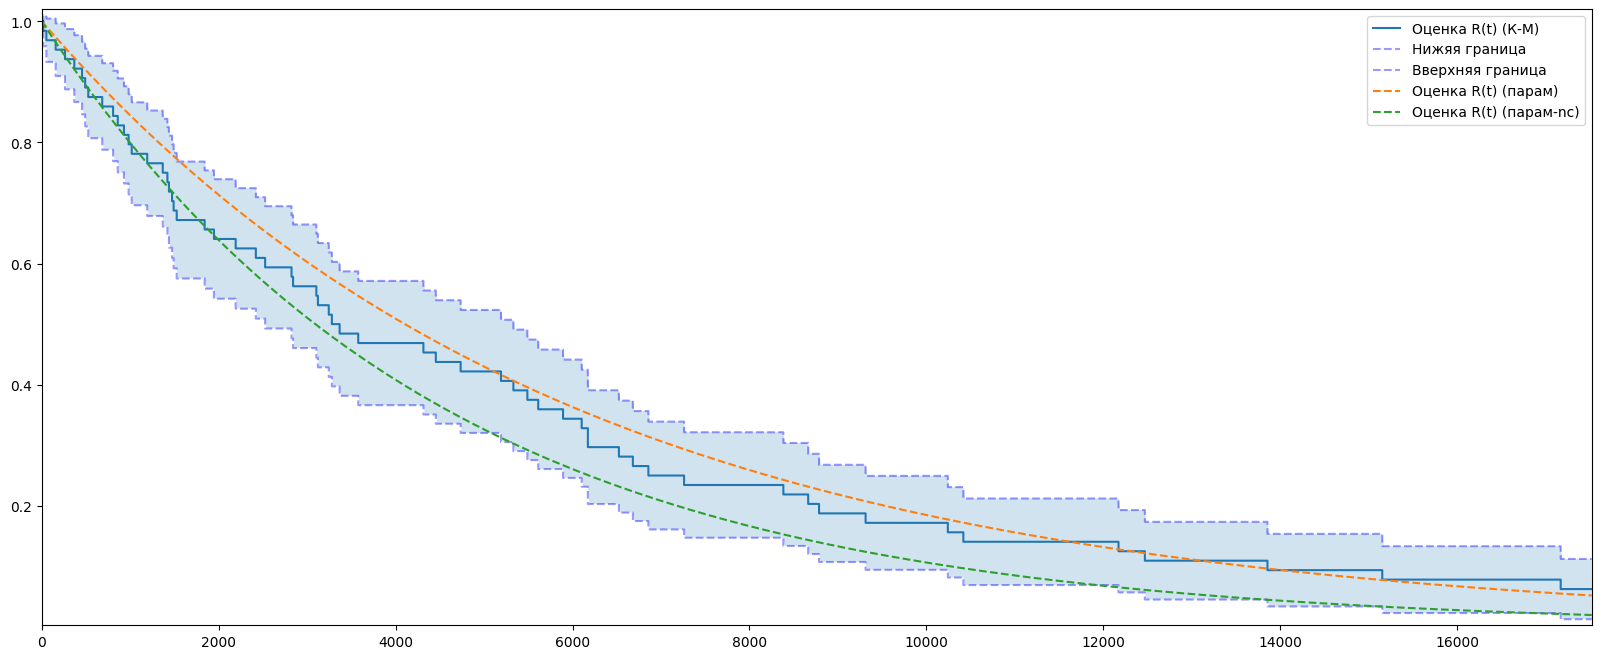

In [22]:
alpha = 0.1
quantile = st.norm.ppf(1-alpha/2)
lower_bound = lambda t: R_est(t) - quantile*sigma_est(t)
upper_bound = lambda t: R_est(t) + quantile*sigma_est(t)

t_vis = np.linspace(0, T, 1000)

lows = [lower_bound(t) for t in t_vis]
ups = [upper_bound(t) for t in t_vis]
ests = [R_est(t) for t in t_vis]
plt.subplots(figsize=(20, 8))
plt.step(t_vis, ests, label='Оценка R(t) (К-М)')
plt.step(t_vis, lows, 'b--', alpha=0.4, label='Нижяя граница')
plt.step(t_vis, ups, 'b--', alpha=0.4, label='Вверхняя граница')
plt.fill_between(t_vis, lows, ups, alpha=0.2)
plt.xlim(0, T)
plt.ylim(min(lows)-1e-2, max(ups)+1e-2)

R_exp = lambda t: np.exp(-lyambda_est*t)
plt.plot(t_vis, R_exp(t_vis), '--', label='Оценка R(t) (парам)')
R_exp_nc = lambda t: np.exp(-lyambda_nc_value*t)
plt.plot(t_vis, R_exp_nc(t_vis), '--', label='Оценка R(t) (парам-nc)')

plt.legend()
plt.show()

#### *3. (\*) Докажите формулу (9.1).* ####

В испытаниях участвуют $n$ объектов. Моменты отказов $t_i$ регистрируются в течение времени $T$, затем регистрация прекращается. При расчетах статистических показателей необходимо учитывать не только значения $t_i$, но и количество агрегатов $k$, все еще работоспособных к моменту $T$. Такие выборки называются цензурированными.

Методом максимального правдоподобия можно получить оценку параметра $\lambda$ экспоненциального распределения для цензурированной выборки:
$$\widehat{\lambda}=\frac{n-k}{\sum{t_i}+kT}$$

Дана выборка $\lbrace t\rbrace=t_1, t_2, ..., t_n$, сделаем оценку параметра $\lambda$ показательного распределения (предполагаем $\tau_i\sim E_\lambda$).\
Причём $t_{n-k+1},...,t_n$ больше $T$.

Цензурированные данные: Для элементов, которые не отказали к времени наблюдения 𝑇 (то есть мы знаем лишь, что объект «прожил» не менее времени 𝑇), вносят в правдоподобие фактор, равный вероятности «дожить» до момента T без отказа.

Будем искать ф.п. как вероятность того, что выборка построена правильным образом

$$\begin{aligned}
L=L(\lambda,\{t_i\})=\prod^n_{i=1}{P_\lambda\{\xi_i=t_i\}}&=\left(\prod^{n-k}_{i=1}{P_\lambda\{\xi_i=t_i\}}\right)\cdot\left(\prod^n_{i=n-k+1}{P_\lambda\{\xi_i>T\}}\right)=\\
=\prod^{n-k}_{i=1}{f(\lambda, t_i)}\cdot (R(\lambda, T))^k&=\prod^{n-k}_{i=1}{(\lambda e^{-\lambda t_i})}\cdot(e^{-\lambda T})^k=\\
=\lambda^{n-k}e^{-\lambda\sum{t_i}}\cdot e^{-k\lambda T}&=\lambda^{n-k}e^{-\lambda(\sum{t_i}+kT)}
\end{aligned}$$

$$\begin{aligned}
L(\lambda, \{t\})&=\lambda^{n-k}e^{-\lambda(\sum{t_i}+kT)}\\
\ln{L(\lambda, \{t\})}&=(n-k)\ln\lambda-\lambda(\sum{t_i}+kT)\\
\frac{\partial\ln{L(\lambda, \{t\})}}{\partial\lambda}&=\frac{n-k}\lambda-(\sum{t_i}+kT)\\
\frac{\partial^2ln{L(\lambda, \{t\})}}{\partial\lambda^2}&=-\frac{n-k}{\lambda^2}
\end{aligned}$$

$$\begin{cases}
\frac{\partial\ln{L(\lambda, \{t_i\})}}{\partial\lambda}=0\\
\frac{\partial^2ln{L(\lambda, \{t_i\})}}{\partial\lambda^2}<0
\end{cases}\Rightarrow
\begin{cases}
\frac{n-k}\lambda-(\sum{t_i}+kT)=0\\
-\frac{n-k}{\lambda^2}<0
\end{cases}\Rightarrow
\begin{cases}
\lambda=\frac{n-k}{\sum{t_i}+kT}\\
\frac{n-k}{\lambda^2}>0
\end{cases}\Rightarrow
\widehat\lambda=\frac{n-k}{\sum{t_i}+kT}$$

#### *4. (\*) Докажите формулу (9.2).* ####

Для больших выборок распределение $\widehat{\lambda}$ близко к нормальному причём:
$$D\widehat{\lambda}=\frac{\lambda^2}{(1-e^{-\lambda T})n}$$

Из №3 известна функция правдоподобия:
$$\begin{aligned}
L(\lambda, \{t\})&=\lambda^{n-k}e^{-\lambda(\sum{t_i}+kT)}\\
\ln{L(\lambda, \{t\})}&=(n-k)\ln\lambda-\lambda(\sum{t_i}+kT)\\
\frac{\partial\ln{L(\lambda, \{t\})}}{\partial\lambda}&=\frac{n-k}\lambda-(\sum{t_i}+kT)\\
\frac{\partial^2ln{L(\lambda, \{t\})}}{\partial\lambda^2}&=-\frac{n-k}{\lambda^2}
\end{aligned}$$

Из курса мат.статистики (В.В. Рыков, В.Ю. Иткин Мат.статистика, п. 7.5):
$$D\widehat\lambda=\frac1{ni(\lambda)}=\frac1{M\left(\frac{\partial\ln L(\lambda,\{t\})}{\partial\lambda}\right)^2}=\frac1{-M\left(\frac{\partial^2\ln L(\lambda,\{t\})}{\partial\lambda^2}\right)}$$
$$-M\left(\frac{\partial^2\ln L(\lambda,\{t\})}{\partial\lambda^2}\right)=M\left(\frac{n-k}{\lambda^2}\right)=\frac{M(n-k)}{\lambda^2}$$

В виду цензорирования типа $I$ имеем $n-k$ - случайную величину, причём 
$$\begin{aligned}
(n-k)&\sim Bi^n_{1-e^{-\lambda T}}\\
M(n-k)&=n(1-e^{-\lambda T})
\end{aligned}$$

$$-M\left(\frac{\partial^2\ln L(\lambda,\{t\})}{\partial\lambda^2}\right)=\frac{n(1-e^{-\lambda T})}{\lambda^2}$$
$$D\widehat\lambda=\frac{\lambda^2}{(1-e^{-\lambda T})n}$$